In [158]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

import time
import os
import copy
from random import randrange
plt.ion()   # interactive mode
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [159]:
import zipfile
with zipfile.ZipFile("Data/Mask.zip","r") as zip_ref:
    zip_ref.extractall("Data")

In [160]:
data_dir = "Data/maskdata/maskdata/"
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) 
                 for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [161]:
class_names = image_datasets['train'].classes
class_names

['with_mask', 'without_mask']

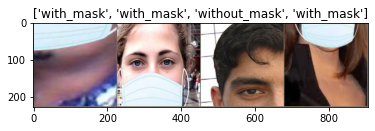

In [162]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [163]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)  # forward
                    _, preds = torch.max(outputs, 1)  # check the lables
                    loss = criterion(outputs, labels)  # compute loss

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # backward
                        optimizer.step()  # Optimization step - update weights

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [164]:
model_ft = models.resnet18(pretrained=True)

In [165]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [166]:
model_ft.fc.in_features

512

In [167]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [168]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=18)

Epoch 0/17
----------
train Loss: 0.6216 Acc: 0.6694
test Loss: 0.4138 Acc: 0.8434

Epoch 1/17
----------
train Loss: 0.6004 Acc: 0.7212
test Loss: 0.1027 Acc: 0.9545

Epoch 2/17
----------
train Loss: 0.4588 Acc: 0.8217
test Loss: 0.2004 Acc: 0.9646

Epoch 3/17
----------
train Loss: 0.3572 Acc: 0.8720
test Loss: 0.1140 Acc: 0.9848

Epoch 4/17
----------
train Loss: 0.3405 Acc: 0.8590
test Loss: 0.7952 Acc: 0.7626

Epoch 5/17
----------
train Loss: 0.3819 Acc: 0.8655
test Loss: 0.3381 Acc: 0.9141

Epoch 6/17
----------
train Loss: 0.3485 Acc: 0.8622
test Loss: 0.2057 Acc: 0.9747

Epoch 7/17
----------
train Loss: 0.2614 Acc: 0.9125
test Loss: 0.0963 Acc: 0.9949

Epoch 8/17
----------
train Loss: 0.2168 Acc: 0.9222
test Loss: 0.0669 Acc: 0.9949

Epoch 9/17
----------
train Loss: 0.2270 Acc: 0.9141
test Loss: 0.0996 Acc: 0.9949

Epoch 10/17
----------
train Loss: 0.2201 Acc: 0.9141
test Loss: 0.0784 Acc: 1.0000

Epoch 11/17
----------
train Loss: 0.2468 Acc: 0.9076
test Loss: 0.1014 Acc

In [169]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

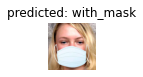

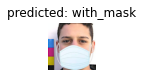

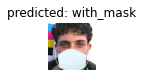

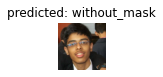

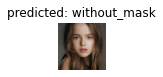

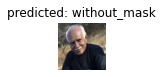

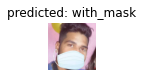

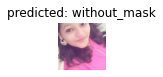

In [170]:
visualize_model(model_ft,num_images=8)

In [171]:
torch.save(model_ft.state_dict(), "Data/mask_model.pth")

In [172]:
model_path = "Data/mask_model.pth"
model_data = torch.load(model_path)
model_ft.load_state_dict(model_data)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

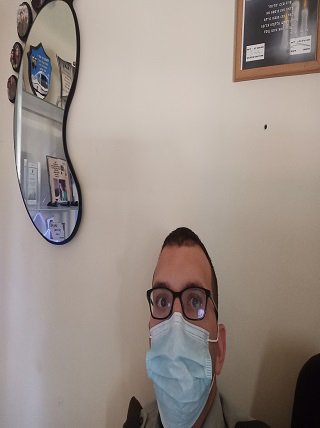

In [173]:
from PIL import Image
img = Image.open("Data/man.jpg")
img

In [174]:
#image preprocessor
loader = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def mask_detector(image_name):
    """load image, returns the class and probability of the class"""
    image = Image.open(image_name)#open image
    tensor = loader(image).float()#convert to tensor
    tensor = Variable(tensor, requires_grad=True)#update tensor to be able to use gradients
    tensor = tensor.unsqueeze(0).cuda() #get tensor to operate on the gpu device
    tensor = model_ft(tensor) #get the tensor on to the resnet
    probs = torch.nn.functional.softmax(tensor, dim=1, _stacklevel=3, dtype=None).cpu().detach().numpy().tolist()[0] #convert output to probabilities
    res = dict(zip(class_names[::-1],probs))#results dictionary (correct order of labels for probabilities)
    return f'The Prediction in this photo is {max(res, key=res.get).split("_")[0]} {max(res, key=res.get).split("_")[1]} with {round(res[max(res, key=res.get)]*100,2)}% certainty' #output


In [175]:
mask_detector("Data/man.jpg")

'The Prediction in this photo is with mask with 73.63% certainty'